In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re                                    #regexp

from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

import string

import nltk
from nltk.corpus import stopwords                   
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB

import warnings
warnings.filterwarnings("ignore")

import random

# Import del dataset

In [2]:
df = pd.read_csv('labeled_data.csv')
df.tail()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies
24782,25296,3,0,0,3,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


# Distribuzione classi

Percentuale di label 0 :  5.770084332001776
Percentuale di label 1 :  77.43211072105879
Percentuale di label 2 :  16.797804946939436


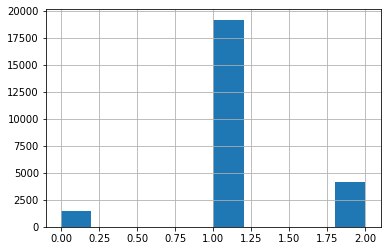

In [3]:
countLabel = np.zeros(3)

for label in df['class']:
    countLabel[label] = countLabel[label] + 1

for index, count in enumerate(countLabel) :
    print('Percentuale di label', index , ': ', 100*(count/df['class'].size))

df['class'].hist()

# Underfitting

In [4]:
columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']

df1 = pd.DataFrame(columns=columns)
df_offensive = pd.DataFrame(columns=columns)

for i in df.index :
    if df['class'][i] == 1 :
        if (i % 2 == 0) :
            df1 = df1.append(df.iloc[i], ignore_index=True)
        else : 
            df_offensive = df_offensive.append(df.iloc[i], ignore_index=True)
    else :
        df1 = df1.append(df.iloc[i], ignore_index=True)
     


In [5]:
df1.tail()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
15125,25290,3,2,1,0,0,you're such a retard i hope you get type 2 dia...
15126,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
15127,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
15128,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
15129,25296,3,0,0,3,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [6]:
df_offensive.tail()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
9648,25282,3,0,3,0,1,"you lil dumb ass bitch, i ain't fuckin wit chu..."
9649,25284,3,0,3,0,1,you look like your 12 stop talking about fucki...
9650,25286,3,1,2,0,1,you niggers cheat on ya gf's? smh....
9651,25288,3,0,3,0,1,"you worried bout other bitches, you need me for?"
9652,25295,6,0,6,0,1,youu got wild bitches tellin you lies


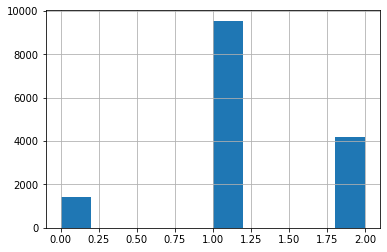

In [7]:
df1['class'].hist()

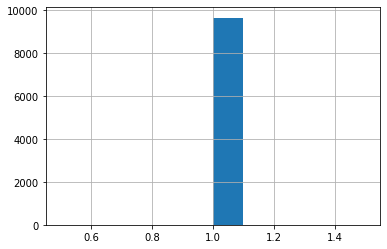

In [8]:
df_offensive['class'].hist()

# Rimozione punteggiatura, numeri e caratteri speciali

In [9]:
def remove_punct_num_spec(tweets):
    
    cleaned_tweets = []  

    for i, tweet in enumerate(tweets) :
        tmp = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet, flags=re.MULTILINE)
        tmp = re.sub(r'@[\w]*', '', tmp)
        tmp = re.sub(r"&amp", '', tmp)
        tmp = re.sub(r"[^A-Za-z\s']+", '', tmp)
        tmp = re.sub(r"\n", '', tmp)
        cleaned_tweets.append(tmp)
        
    return cleaned_tweets

def remove_punct_num_spec_singleTweet (tweet):
    
    tmp = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet, flags=re.MULTILINE)
    tmp = re.sub(r'@[\w]*', '', tmp)
    tmp = re.sub(r"&amp", '', tmp)
    tmp = re.sub(r"[^A-Za-z\s']+", '', tmp)
    tmp = re.sub(r"\n", '', tmp)
    
    return tmp
    

In [10]:
tweets = df1.tweet
cleaned_tweets = remove_punct_num_spec(tweets)
cleaned_tweets[:5]

[" RT  As a woman you shouldn't complain about cleaning up your house  as a man you should always take the trash out",
 ' RT  Dawg RT  You ever fuck a bitch and she start to cry You be confused as shit',
 ' RT  The shit you hear about me might be true or it might be faker than the bitch who told it to ya ',
 ' I can not just sit up and HATE on another bitch  I got too much shit going on',
 '  you might not get ya bitch back  thats that ']

# Tokenizers

In [11]:
def tweets_tokenize (tweets, tokenizer, stop_words) :

    tokenized_tweets = []
    new_sentence = []

    for tweet in tweets :
        text = tokenizer.tokenize(tweet) 
        for w in text:
            if w.lower() not in stop_words:   
                new_sentence.append(w.lower())

        tokenized_tweets.append(new_sentence)
        new_sentence = []
        
    return tokenized_tweets


def tokenize (tweet) :
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = (stopwords.words('english'))
    exclusions = ['rt', 'u']
    stop_words.extend(exclusions)
    stemmer = SnowballStemmer('english')
    
    new_sentence = []
    text = tokenizer.tokenize(tweet) 
    for w in text:
        if w.lower() not in stop_words:   
            new_sentence.append(w.lower())

    return stem_single_tweet(new_sentence, stemmer)

def basic_tokenize (tweet) :
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = (stopwords.words('english'))
    exclusions = ['rt', 'u']
    stop_words.extend(exclusions)
    stemmer = SnowballStemmer('english')
    
    new_sentence = []
    text = tokenizer.tokenize(tweet) 
    for w in text:
        if w.lower() not in stop_words:   
            new_sentence.append(w.lower())

    return new_sentence


In [12]:
tokenizer = RegexpTokenizer(r'\w+')

stop_words = (stopwords.words('english'))
exclusions = ['rt', 'u']
stop_words.extend(exclusions)


tokenized_tweets = tweets_tokenize(cleaned_tweets, tokenizer, stop_words)
print(stop_words)
print('------------------------')
print(tokenized_tweets[:5])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Stemming

In [13]:
def stem (tokenized_tweets, stemmer) :
    tokenized_stemmed = []

    for tweet in tokenized_tweets:
        tokenized_stemmed.append([stemmer.stem(word) for word in tweet])
        
    return tokenized_stemmed

def stem_single_tweet (tweet, stemmer) :
    tokenized_stemmed = []

    return [stemmer.stem(word) for word in tweet]
    

In [14]:
stemmer = SnowballStemmer('english')
stemmed_tweets = stem(tokenized_tweets, stemmer)
print(stemmed_tweets[:5])

[['woman', 'complain', 'clean', 'hous', 'man', 'alway', 'take', 'trash'], ['dawg', 'ever', 'fuck', 'bitch', 'start', 'cri', 'confus', 'shit'], ['shit', 'hear', 'might', 'true', 'might', 'faker', 'bitch', 'told', 'ya'], ['sit', 'hate', 'anoth', 'bitch', 'got', 'much', 'shit', 'go'], ['might', 'get', 'ya', 'bitch', 'back', 'that']]


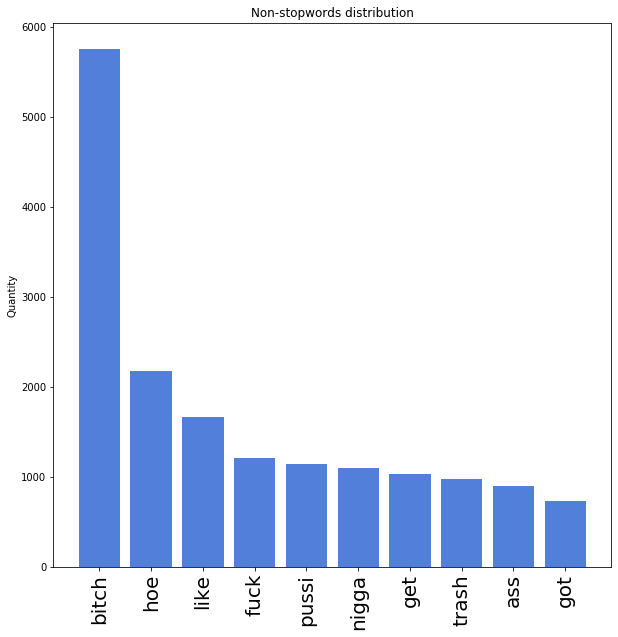

In [15]:
dicti = {}

from collections import Counter 
  

for tweet in stemmed_tweets :
    for word in tweet :
        dicti[word] = 0
for tweet in stemmed_tweets :
    for word in tweet :
        dicti[word] = dicti[word] + 1
        
import collections 
k = Counter(dicti)
sorted_dict = dict(k.most_common(10))  

product_quantity_figure = plt.figure(figsize=(10,10))
ax = product_quantity_figure.add_subplot(111)
ax.set(title='Non-stopwords distribution', ylabel='Quantity')
ax.bar(sorted_dict.keys(),sorted_dict.values(),
color='#527fd9', linewidth=1)
xtickNames = ax.set_xticklabels(sorted_dict.keys())
plt.setp(xtickNames , rotation=90, fontsize=20)
plt.show()



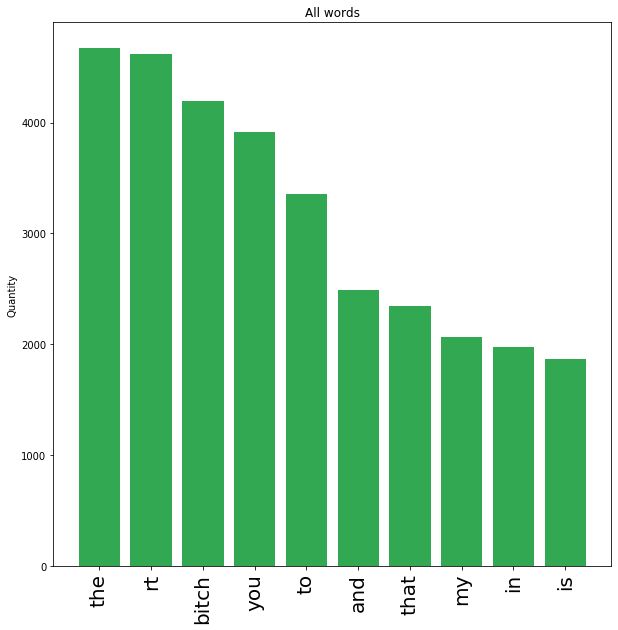

In [16]:
dicti = {}

from collections import Counter 
  

for tweet in tweets_tokenize (cleaned_tweets, tokenizer, []) :
    for word in tweet :
        if len(word) > 1:
            dicti[word] = 0
for tweet in tweets_tokenize (cleaned_tweets, tokenizer, []) :
    for word in tweet :
        if len(word) > 1:
            dicti[word] = dicti[word] + 1
        
import collections 
k = Counter(dicti)
sorted_dict = dict(k.most_common(10))  

product_quantity_figure = plt.figure(figsize=(10,10))
ax = product_quantity_figure.add_subplot(111)
ax.set(title='All words', ylabel='Quantity')
ax.bar(sorted_dict.keys(),sorted_dict.values(),
color='#32a852', linewidth=1)
xtickNames = ax.set_xticklabels(sorted_dict.keys())
plt.setp(xtickNames , rotation=90, fontsize=20)
plt.show()


In [17]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=remove_punct_num_spec_singleTweet,
    ngram_range=(1, 3),
    max_features=10000
)

X = vectorizer.fit_transform(df1.tweet)
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())[523:527]

,aap,aaron,ab,abil,abl,abo,abort,absolut,abt,abu,...,yup,z,zebra,zero,zijn,zimmerman,zip,zoe,zone,zoom
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# POS Tagging

In [18]:
def POS_tag (tweets) :
    tweet_tags = []
    for t in tweets:
        tokens = basic_tokenize(remove_punct_num_spec_singleTweet(t))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        tag_str = " ".join(tag_list)
        tweet_tags.append(tag_str)

    return tweet_tags

POS_tags = POS_tag(df1.tweet)
POS_tags[:10]

['NN VB NN NN NN RB VBP NN',
 'NN RB VBD JJ NN NN VBD NN',
 'NNS JJ MD JJ MD VB NN VBD NN',
 'NN NN DT NN VBD JJ NN VBG',
 'MD VB JJ VB RB NNS',
 'NNS VBP NNS NN NN VBD NN IN NN',
 'NNS VBD NNS RB VBP JJ',
 'NN NN',
 'NN NN WDT',
 'NNS VBP VBN JJ NN']

In [19]:
pos_vect = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    use_idf=False,
    smooth_idf=False,
    )

pos = pos_vect.fit_transform(pd.Series(POS_tags))
pd.DataFrame(pos.toarray(), columns=pos_vect.get_feature_names())[27:30]

,CC,CC CD,CC CD NN,CC CD NNS,CC IN,CC IN NN,CC JJ,CC JJ JJ,CC JJ NN,CC JJ NNS,...,WRB NN VB,WRB NN VBZ,WRB NNS,WRB NNS VBP,WRB VB,WRB VB NNS,WRB VBP,WRB VBP IN,WRB VBP JJ,WRB VBP NN
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Altre features 

In [20]:
def other_features(tweet):
   
    sentiment_analyzer = VS()
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = remove_punct_num_spec_singleTweet(tweet) 

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    retweet = 0
    if "rt" in words:
        retweet = 1
        
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, 
                num_terms, num_words, num_unique_terms, sentiment['neg'], 
                sentiment['pos'], sentiment['neu'], sentiment['compound'], retweet]
    return features

other_features(df1.tweet[0])

[9.1, 69.14, 30, 1.3636, 114, 140, 25, 22, 20, 0.0, 0.12, 0.88, 0.4563, 0]

In [21]:
def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

feats = get_feature_array(tweets)
M = np.concatenate([X.toarray(),pos.toarray(),feats],axis=1)


vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

pos_dict = {v:i for i, v in enumerate(pos_vect.get_feature_names())}

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", \
                        "num_chars", "num_chars_total", "num_terms", "num_words", \
                        "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "is_retweet"]

#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_dict)
for k,v in pos_dict.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names
pd.DataFrame(M, columns=feature_names)[27:30]



,aap,aaron,ab,abil,abl,abo,abort,absolut,abt,abu,...,num_chars,num_chars_total,num_terms,num_words,num_unique_words,vader neg,vader pos,vader neu,vader compound,is_retweet
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66.0,191.0,12.0,11.0,11.0,0.000,0.134,0.866,0.1779,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,84.0,188.0,23.0,19.0,17.0,0.280,0.000,0.720,-0.7906,0.0
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,57.0,12.0,11.0,11.0,0.266,0.175,0.559,-0.3182,0.0


# Splitting test set e training set

In [22]:
X = pd.DataFrame(M)
y = df1['class'].astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

# Oversampling con SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
#
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {} \n".format(sum(y_train==2)))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))


Before OverSampling, counts of label '0': 1292
Before OverSampling, counts of label '1': 8580
Before OverSampling, counts of label '2': 3745 

After OverSampling, the shape of train_X: (25740, 13278)
After OverSampling, the shape of train_y: (25740,) 

After OverSampling, counts of label '0': 8580
After OverSampling, counts of label '1': 8580
After OverSampling, counts of label '2': 8580


In [25]:
#Utilizzare i seguenti classificatori consuma molta ram. MemoryError dovuto a questo motivo. Utilizzo garbage collector
#per liberare memoria inutilizzata
import gc
gc.collect()

22

# Cross Validation

In [26]:
#Decommentare linea con cross_validate e commentare linea con dict per testare il cross validation

LR = LogisticRegression(solver='lbfgs', max_iter=100, multi_class="auto")
#cv_LR = cross_validate(LR, X_train_res, y_train_res, cv=5, verbose=True)

cv_LR = {'fit_time': np.array([54.2619555 , 51.10488844, 58.42432714, 62.23602962, 66.02006364]),
         'score_time': np.array([0.14361835, 0.1146934 , 0.12267327, 0.14561105, 0.19448018]),
         'test_score': np.array([0.44133644, 0.44366744, 0.43881119, 0.41297591, 0.5460373 ])}

In [37]:
#Decommentare linea con cross_validate e commentare linea con dict per testare il cross validation

DTC = DecisionTreeClassifier(max_depth=20)
#cv_DTC = cross_validate(DTC, X_train_res, y_train_res, cv=5, verbose=True)

cv_DTC = {'fit_time': np.array([162.88127065, 177.49825668, 177.92293787, 182.17597175,191.8862071 ]),
        'score_time': np.array([0.27349138, 0.25332284, 0.24034286, 0.2224052 , 0.25631475]),
         'test_score': np.array([0.82439782, 0.90345765, 0.91550117, 0.92812743, 0.92404817])}

In [28]:
SVC = svm.SVC(gamma='scale')
#cv_SVC = cross_validate(SVC, X_train_res, y_train_res, cv=5, verbose=True)

In [29]:
#Decommentare linea con cross_validate e commentare linea con dict per testare il cross validation

BNB = BernoulliNB()
#cv_BNB = cross_validate(BNB, X_train_res, y_train_res, cv=5, verbose=True)

cv_BNB = {'fit_time': np.array([3.38698387, 3.48072243, 3.37796497, 3.53075981, 3.33708167]),
         'score_time': np.array([0.6272862 , 0.601367  , 0.57743287, 0.57243752, 0.56246519]),
         'test_score': np.array([0.68026418, 0.77389277, 0.86052836, 0.87587413, 0.87470862])}

# Analisi tempi di fitting

In [30]:
total_times = {
    'LR': 0.0,
    'DTC': 0.0,
    'SVC': 0.0,
    'BNB': 0.0
}

def times (model, name) :
    for time in model['fit_time'] :
        
        total_times[name] = total_times[name] + time
        
    return total_times[name]

total_times['LR'] = times(cv_LR, 'LR')
total_times['DTC'] = times(cv_DTC, 'DTC')
#total_times['SVC'] = times(cv_SVC, 'SVC')
total_times['BNB'] = times(cv_BNB, 'BNB')

total_times

{'LR': 292.04726433999997,
 'DTC': 892.3646440499999,
 'SVC': 0.0,
 'BNB': 17.113512749999998}

<BarContainer object of 4 artists>

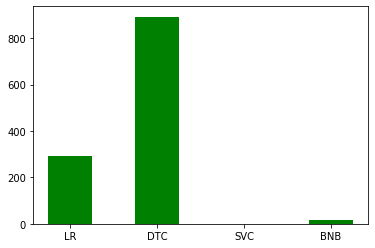

In [31]:
plt.bar(total_times.keys(), total_times.values(), 0.5, color='g')

# Fitting dei modelli

In [38]:
#LR_model = LR.fit(X_train_res, y_train_res)
DTC_model = DTC.fit(X_train_res, y_train_res)
#SVC_model = SVC.fit(X_train_res, y_train_res)
#BNB_model = BNB.fit(X_train_res, y_train_res)

# Predictions

In [39]:
y_preds_LR = LR_model.predict(X_test)
y_preds_DTC = DTC_model.predict(X_test)
#y_preds_SVC = SVC_model.predict(X_test)
y_preds_BNB = BNB_model.predict(X_test)

# Confusion Matrix

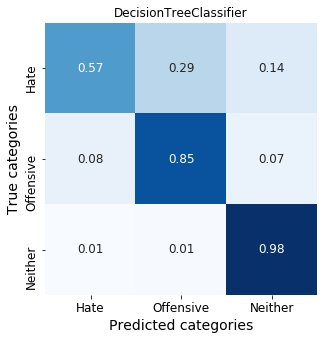

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn

confusion_matrix = confusion_matrix(y_test,y_preds_DTC)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
plt.title('DecisionTreeClassifier')
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues', cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

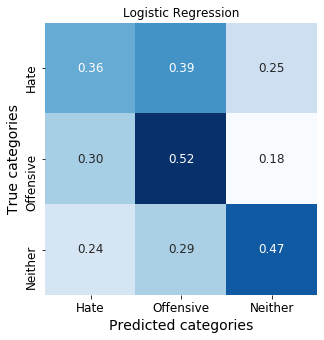

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn

confusion_matrix = confusion_matrix(y_test,y_preds_LR)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
plt.title('Logistic Regression')
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

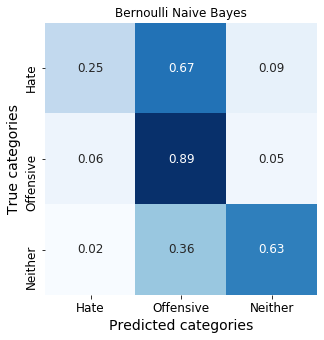

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn

confusion_matrix = confusion_matrix(y_test,y_preds_BNB)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
plt.title('Bernoulli Naive Bayes')
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)